# Desafio Cientista de Dados Hospital Albert Einstein

Data: 02/02/2021

### This is a small and straightforward test developed by HIAE to check the basics of machine learning.


#### Instructions
1. Choose your programming language of interest: R or Python;
2. Your results can be presented in any format. We suggest using a Jupyter
Notebook (for Python users) or RMarkDown (for R users);
3. Add comments to the main steps of your code (in English);
4. Consider that the results will be presented for a non-technical audience so
try to emphasize the results of your work in a clear manner.


##### Problem Statement
Build a classifier model using the given dataset to predict the target classes.
1. Choose two different models of your choice to solve the problem;
2. Give a brief explanation of why you picked them;
3. Compare and argue over the results of the models.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
# carrega os dados

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('df_data.csv')
df.head()

,x1,x2,x3,target
0,2.71,10.39,-36.45,med
1,9.88,5.76,-54.63,med
2,82.87,1.73,0.83,med
3,12.99,10.40,-59.60,med
4,60.10,8.84,-45.87,med


In [20]:
# descrição das estatísticas básicas

df.describe()

,x1,x2,x3
count,10000.000000,10000.000000,10000.000000
mean,42.669613,9.023236,-24.603198
std,25.597848,5.180151,20.138584
min,-19.500000,0.170000,-59.980000
25%,21.675000,5.260000,-41.920000
50%,42.940000,8.075000,-24.555000
75%,64.135000,11.730000,-7.080000
max,101.520000,43.080000,9.990000


In [21]:
# distribuição da variável Target

df.target.value_counts()

low     6000
high    3000
med     1000
Name: target, dtype: int64

In [22]:
# verifica existência de valores NaN

for column in df:
    if df[column].isnull().any():
       print('{0} has {1} null values'.format(column, df[column].isnull().sum()))

In [23]:
# Label encoder para transformar variáveis com formato string em números

from sklearn.preprocessing import LabelEncoder
list_encoder = ['target']

for col in list_encoder:
    X = df.loc[:, [col]].values
    le = LabelEncoder()
    X[:, 0] = le.fit_transform(X[:, 0])
    df[col] = X

In [24]:
# A função abaixo verifica a existência de valores outliers em cada coluna

def detect_outlier(data, threshold=3):
    df_outlier = pd.DataFrame()
    
    for col in data.columns:
        mean, std = np.mean(data[col]), np.std(data[col])
        outliers=[]
        
        for y in data[col]:
            z_score = (y - mean)/std
            
            if np.abs(z_score) > threshold or np.abs(z_score) < - threshold:  
                outliers.append(y)
        df2 = pd.DataFrame({'variável': [col], 'quantidade': [len(set(outliers))]})
        df_outlier = df_outlier.append(df2)
        df_outlier = df_outlier.loc[df_outlier.quantidade > 0]  
          
    return df_outlier

outliers = detect_outlier(df)
outliers

,variável,quantidade
0,x2,104


Mesmo que encontrado valores outliers, nenhuma ação foi seguida, visto que alguns testes foram feitos, como por exemplo substituição dos valores discrepantes pela média da variável, e o resultado foi bem similar.

In [25]:
# Normalização dos dados

from sklearn.preprocessing import Normalizer

df = df.astype(int)
numeric_columns = ['x1', 'x2', 'x3']

scaler = Normalizer().fit(df[numeric_columns].values)
standardX = scaler.transform(df[numeric_columns].values)
df[numeric_columns] = standardX
round(df[numeric_columns].describe().T,3)

,count,mean,std,min,25%,50%,75%,max
x1,10000.0,0.719,0.304,-0.824,0.588,0.829,0.949,1.00
x2,10000.0,0.199,0.175,0.000,0.085,0.146,0.248,1.00
x3,10000.0,-0.434,0.363,-1.000,-0.729,-0.475,-0.149,0.97


In [26]:
# Verificando a importância dos Atributos com o Extra Trees Classifier

# Import dos Módulos
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings("ignore")

# Separando o array em componentes de input e output

X = df.drop(['target'], axis=1).values
Y = df.target.values

# Criação do Modelo - Feature Selection
modelo = ExtraTreesClassifier()
modelo.fit(X, Y)

X_features = df.drop(['target'], axis=1)

# Lista de colunas a serem usadas para treinar cada modelo
features = [col for col in list(X_features) ]
importances =  modelo.feature_importances_
descending_indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in descending_indices]
sorted_features = [features[idx] for idx in descending_indices]
print('As Variáveis mais importantes são %s' % sorted_features)

As Variáveis mais importantes são ['x1', 'x3', 'x2']


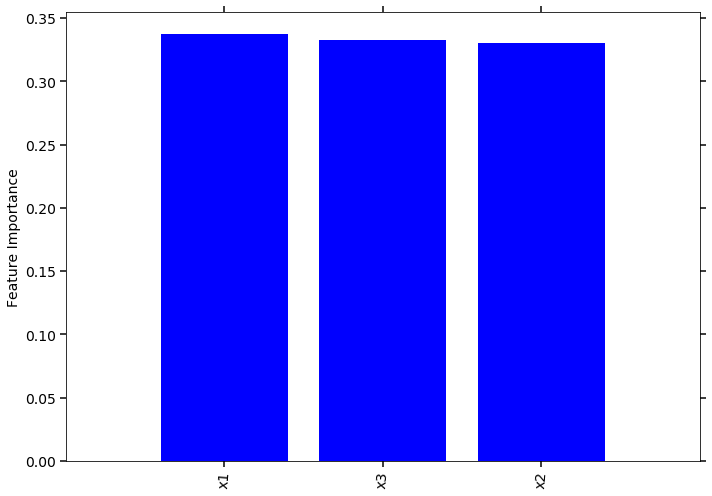

In [27]:
# plot das variáveis em um eixo de impacto nas previsões

def plot_importances(X_features, sorted_features, sorted_importances):

    axis_width = 1.5
    maj_tick_len = 6
    fontsize = 14
    bar_color = 'blue'
    align = 'center'
    label = '__nolegend__'
    ax = plt.bar(range(X_features.shape[1]), sorted_importances, color=bar_color, align=align, label=label)
    ax = plt.xticks(range(X_features.shape[1]), sorted_features, rotation=85)
    ax = plt.xlim([-1, X_features.shape[1]])
    ax = plt.ylabel('Feature Importance', fontsize=fontsize)
    ax = plt.tick_params('both', length=maj_tick_len, width=axis_width, which='major', right=True, top=True)
    ax = plt.xticks(fontsize=fontsize)
    ax = plt.yticks(fontsize=fontsize)
    ax = plt.tight_layout()
    return ax

fig1 = plt.figure(1, figsize=(10,7))
ax = plot_importances(X_features, sorted_features, sorted_importances)

plt.show()
plt.close()

O código abaixo testa 3 algoritmos diferentes, utilizando uma técnica de cross validation.

Essa etapa ajuda a identificar as diferentes performances de cada algoritmo e a escolha adequada.

Para cada algoritmo, 5 conjuntos de dados de treinamento e teste distintos e aleatórios serão gerados para previsão e avaliação de cada um dos modelos.

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



X = df.drop(['target'], axis=1).values
Y = df.target.values

num_folds = 5
modelos = []
resultados = []
nomes = []

modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('DecisionTree', DecisionTreeClassifier()))
modelos.append(('RandomForest', RandomForestClassifier(n_estimators=100)))

for nome, modelo in modelos:
    kfold = KFold(num_folds, True)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f %f (%f)" % (nome, cv_results.mean(), cv_results.max(), cv_results.std())
    print(msg)

KNN: 0.520800 0.528000 (0.004986)
DecisionTree: 0.453600 0.463500 (0.008969)
RandomForest: 0.517800 0.533000 (0.008920)


Seguindo com o KNN, abaixo temos outros resultados de avaliação do modelo.

In [29]:
# Divisão em dados de treino e de teste

from sklearn.model_selection import train_test_split

X_treino, testeData, Y_treino, testeLabels = train_test_split(X, Y, test_size = 0.30)

# treino do modelo final e previsões nos dados de teste

modeloKNN = KNeighborsClassifier()
modeloKNN.fit(X_treino, Y_treino)

ypred = modeloKNN.predict(testeData)

# Avaliação do modelo

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ConfusionMatrix = confusion_matrix(testeLabels, ypred)
print("Confusion Matrix:")
print(ConfusionMatrix, '\n')

ClassificationReport = classification_report(testeLabels, ypred)
print("Classification Report:",)
print (ClassificationReport, '\n')

accuracy = accuracy_score(testeLabels, ypred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[ 253  658   17]
 [ 489 1282   19]
 [  75  204    3]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.27      0.29       928
           1       0.60      0.72      0.65      1790
           2       0.08      0.01      0.02       282

    accuracy                           0.51      3000
   macro avg       0.33      0.33      0.32      3000
weighted avg       0.46      0.51      0.48      3000
 

Accuracy: 0.5126666666666667


Ao analisarmos o f1-score do modelo acima, podemos notar que há uma permormace ruim para as previsões quando a variável target é igual a 0 ou igual 2, isso porque as classes estão desbalanceadas, como pode ser visto abaixo, o modelo aprende muito mais sobre dados onde a previsão da variável target é igual a 1.

In [30]:
# distribuição da variável target nos dados de treino:

df.target.value_counts()

1    6000
0    3000
2    1000
Name: target, dtype: int64

Algumas técnicas distintas podem ser aplicadas pra resolver esse problema, como coleta de amostras aleatórias dentro do próprio dataset de treino, mas como o volume de dados é pequeno, resolvi aplicar SMOTE que cria dados sintéticos de acordo com cada variável no dataset em questão, igualando as classes a serem previstas:

In [31]:
from imblearn.over_sampling import SMOTE
from collections import Counter

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
counter = Counter(Y)
print(counter)

Counter({2: 6000, 1: 6000, 0: 6000})


In [32]:
# treino do modelo com o dataset balanceado e previsões nos dados de teste

X_treino, testeData, Y_treino, testeLabels = train_test_split(X, Y, test_size = 0.30)
modeloKNN = KNeighborsClassifier()
modeloKNN.fit(X_treino, Y_treino)
ypred = modeloKNN.predict(testeData)

# Avaliação do modelo

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ConfusionMatrix = confusion_matrix(testeLabels, ypred)
print("Confusion Matrix:")
print(ConfusionMatrix, '\n')

ClassificationReport = classification_report(testeLabels, ypred)
print("Classification Report:",)
print (ClassificationReport, '\n')

accuracy = accuracy_score(testeLabels, ypred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1098  388  273]
 [ 754  661  400]
 [ 355  296 1175]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55      1759
           1       0.49      0.36      0.42      1815
           2       0.64      0.64      0.64      1826

    accuracy                           0.54      5400
   macro avg       0.54      0.54      0.54      5400
weighted avg       0.54      0.54      0.54      5400
 

Accuracy: 0.5433333333333333


Agora com os dados balanceados, podemos otimizar o valor de k para otimizar os resultados do modelo.

In [33]:
# Otimização do valor de K

from sklearn.model_selection import train_test_split

# Divisão em dados de treino e de teste
X_treino, testeData, Y_treino, testeLabels = train_test_split(X, Y, test_size = 0.30)

# Range de valores de k que iremos testar
kVals = range(3, 30, 2)

# Lista vazia para receber as acurácias
acuracias = []

# Loop em todos os valores de k para testar cada um deles
for k in kVals:
    
    # Treinando o modelo KNN com cada valor de k
    modeloKNN = KNeighborsClassifier(n_neighbors = k)
    modeloKNN.fit(X_treino, Y_treino)
          
    # Avaliando o modelo e atualizando a lista de acurácias
    score = modeloKNN.score(testeData, testeLabels)
    print("Com valor de k = %d, a acurácia é = %.2f%%" % (k, score * 100))
    acuracias.append(score)

Com valor de k = 3, a acurácia é = 55.56%
Com valor de k = 5, a acurácia é = 55.15%
Com valor de k = 7, a acurácia é = 53.37%
Com valor de k = 9, a acurácia é = 52.06%
Com valor de k = 11, a acurácia é = 51.13%
Com valor de k = 13, a acurácia é = 50.87%
Com valor de k = 15, a acurácia é = 50.28%
Com valor de k = 17, a acurácia é = 50.09%
Com valor de k = 19, a acurácia é = 49.41%
Com valor de k = 21, a acurácia é = 48.72%
Com valor de k = 23, a acurácia é = 48.69%
Com valor de k = 25, a acurácia é = 48.04%
Com valor de k = 27, a acurácia é = 47.74%
Com valor de k = 29, a acurácia é = 47.07%


Note que conforme o valor de K aumenta, a acurácia do modelo tende a cair.

In [34]:
# treino do modelo final com k =3 e previsões nos dados de teste

modeloKNN = KNeighborsClassifier(n_neighbors = 3)
modeloKNN.fit(X_treino, Y_treino)

ypred = modeloKNN.predict(testeData)

# Avaliação do modelo

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ConfusionMatrix = confusion_matrix(testeLabels, ypred)
print("Confusion Matrix:")
print(ConfusionMatrix, '\n')

ClassificationReport = classification_report(testeLabels, ypred)
print("Classification Report:",)
print (ClassificationReport, '\n')

accuracy = accuracy_score(testeLabels, ypred)
print("Accuracy:", accuracy)

Confusion Matrix:
[[1151  421  252]
 [ 707  652  447]
 [ 382  191 1197]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.63      0.57      1824
           1       0.52      0.36      0.42      1806
           2       0.63      0.68      0.65      1770

    accuracy                           0.56      5400
   macro avg       0.55      0.56      0.55      5400
weighted avg       0.55      0.56      0.55      5400
 

Accuracy: 0.5555555555555556


É notável o ganho de performance entre os modelos criados a cada otimização realizada, principalmente na etapa de balanceamento das classes.O f1-score do modelo para previsão do classe 'med' teve um ganho de performance gigantesco em comparação ao primeiro modelo com os as classes desbalanceadas. 

A etapa de normalização é importante para colocar os dados em uma mesma escala, principalmente quando escolhido utilizar o KNN, que por ter como base de cálculo a distância entre pontos, apresenta resultados e performance melhores com a normalização, essa etapa também trouxe melhorias em todas as métricas do report em comparação ao modelo anterior.
